<a href="https://colab.research.google.com/github/tdisheng/Deep-Learning-Projects/blob/main/Mask_Inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

This project aims to be able to take in a picture of someone wearing a mask and output a picture of how they would look like without the mask. The project will be split into two segments:

1. Training a UNet segmentation model to identify the binary image of the mask from the masked image
2. Training a GAN network (pix2pix) with custom losses to generate the desired image without the mask, using the binary image of the mask as well as the masked image

The dataset used will be the CelebA dataset with 197,016 images. Not all of the 202,599 images in the dataset will be used as the face_recognition module used are not able to detect all of the faces in the dataset. Also, we need enough data to train over a large distribution of faces to be able to generate a face with believable facial features.

### Preparation

## Importing Required Modules

face_recognition is used for detecting faces and identifying facial landmarks for putting on a mask on the face. Not needed for inference

VGGFace is a VGG model trained for Facial Recognition which we will use to calculate perceptual loss

In [ ]:
import pandas as pd
import numpy as np
import random
import time
import os, json
import math
from glob import glob

# %matplotlib inline

from tensorflow.keras import optimizers
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Conv2D, MaxPooling2D, Reshape, UpSampling2D, multiply, concatenate, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from tensorflow.image import grayscale_to_rgb

import tensorflow as tf
from keras.models import load_model
from IPython.display import clear_output
from skimage.measure import EllipseModel
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from configparser import ConfigParser

from datetime import datetime


import cv2

!pip install -qq face_recognition
import face_recognition
import dlib
!pip install -qq dotmap
from dotmap import DotMap

!pip install -qq git+https://github.com/rcmalli/keras-vggface.git
!pip install -qq keras_applications
from keras_vggface.vggface import VGGFace

print(tf.__version__)
print(tf.keras.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

!nvidia-smi

     |████████████████████████████████| 100.2MB 35kB/s 
     |████████████████████████████████| 51kB 2.7MB/s 
2.5.0
2.5.0
Found GPU at: /device:GPU:0
Sun Jun 13 16:42:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    56W / 149W |    157MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-----------------

## Importing data used to train our models

In interest of time, the images have already been pre-processed and stored in a Google Cloud Bucket, where each example contains the original image, the original image with a mask over it as well as the binary mask output

We then resize the image down to 128x128, which significantly reduces training time on a P100 GPU from 10 hours per epoch to about 1.5 hours per epoch

In [ ]:
def read_tfrecord(example):
    features = {
        "masked_image": tf.io.FixedLenFeature((), tf.string),
        "mask_binary": tf.io.FixedLenFeature((), tf.string),
        "original_image": tf.io.FixedLenFeature((), tf.string)
    }
    example = tf.io.parse_single_example(example, features)
    if RECOMPRESS:
      masked_image = tf.image.decode_jpeg(example['masked_image'])
      mask_binary = tf.image.decode_jpeg(example['mask_binary'])
      original_image = tf.image.decode_jpeg(example['original_image'])
    else:
      masked_image = tf.io.decode_raw(example['masked_image'], out_type=tf.uint8)
      mask_binary = tf.io.decode_raw(example['mask_binary'], out_type=tf.uint8)
      original_image = tf.io.decode_raw(example['original_image'], out_type=tf.uint8)

    masked_image = tf.cast(masked_image, tf.float32)
    mask_binary = tf.cast(mask_binary, tf.float32)
    original_image = tf.cast(original_image, tf.float32)

    # Resize image to 128 x 128 pixels
    original_image = tf.image.resize(original_image, (128,128))
    mask_binary = tf.image.resize(mask_binary, (128,128))
    masked_image = tf.image.resize(masked_image, (128,128))

    # Normalizing pixel values to be between [-1, 1]
    masked_image = (masked_image / 127.5) - 1
    mask_binary = (mask_binary / 127.5) - 1
    original_image = (original_image / 127.5) - 1

    return masked_image, mask_binary, original_image
    
GCS_OUTPUT = 'gs://celeb_faces_tfrecords/256x256/celeb-'
RECOMPRESS = True

# read from tfrecs
filenames = tf.data.Dataset.list_files(GCS_OUTPUT + "*.tfrec")
records = tf.data.TFRecordDataset(filenames)
dataset = records.map(read_tfrecord)
dataset = dataset.shuffle(300).batch(32)

# Splitting into Training and Testing datasets
test_dataset = dataset.take(300) # 32 * 300 = 9600 testing examples
train_dataset = dataset.skip(300)

In [ ]:
# masks for masking the face

!gdown --id "1NVMUyP6jd6Yo06CSfoPMHQBxa5xwSP-1"
!unzip masks.zip
!rm masks.zip

Downloading...
From: https://drive.google.com/uc?id=1NVMUyP6jd6Yo06CSfoPMHQBxa5xwSP-1
To: /content/masks.zip
18.9MB [00:00, 164MB/s]
Archive:  masks.zip
  inflating: masks/templates/gas_right.png  
  inflating: masks/masks.cfg         
  inflating: masks/templates/surgical_blue_right.png  
  inflating: masks/textures/fruits/lemon.png  
  inflating: masks/templates/surgical_left.png  
  inflating: masks/templates/KN95_right.png  
  inflating: masks/templates/surgical_blue.png  
  inflating: masks/templates/N95_left.png  
  inflating: masks/templates/gas_left.png  
  inflating: masks/templates/surgical.png  
  inflating: masks/templates/cloth_left.png  
  inflating: masks/templates/surgical_right.png  
  inflating: masks/templates/KN95.png  
  inflating: masks/templates/cloth_right.png  
  inflating: masks/templates/KN95_left.png  
  inflating: masks/textures/fruits/pineapple.png  
  inflating: masks/templates/surgical_blue_left.png  
  inflating: masks/templates/cloth.png  
  inflating:

## Masking the Face

Modules from MaskTheFace (https://github.com/aqeelanwar/MaskTheFace) which will be used to mask the face in the images

In [ ]:
# functions from MaskTheFace (https://github.com/aqeelanwar/MaskTheFace)

def get_line(face_landmark, image, type="eye", debug=False):
    pil_image = Image.fromarray(image)
    d = ImageDraw.Draw(pil_image)
    left_eye = face_landmark["left_eye"]
    right_eye = face_landmark["right_eye"]
    left_eye_mid = np.mean(np.array(left_eye), axis=0)
    right_eye_mid = np.mean(np.array(right_eye), axis=0)
    eye_line_mid = (left_eye_mid + right_eye_mid) / 2

    if type == "eye":
        left_point = left_eye_mid
        right_point = right_eye_mid
        mid_point = eye_line_mid

    elif type == "nose_mid":
        nose_length = (
            face_landmark["nose_bridge"][-1][1] - face_landmark["nose_bridge"][0][1]
        )
        left_point = [left_eye_mid[0], left_eye_mid[1] + nose_length / 2]
        right_point = [right_eye_mid[0], right_eye_mid[1] + nose_length / 2]
        # mid_point = (
        #     face_landmark["nose_bridge"][-1][1] + face_landmark["nose_bridge"][0][1]
        # ) / 2

        mid_pointY = (
            face_landmark["nose_bridge"][-1][1] + face_landmark["nose_bridge"][0][1]
        ) / 2
        mid_pointX = (
            face_landmark["nose_bridge"][-1][0] + face_landmark["nose_bridge"][0][0]
        ) / 2
        mid_point = (mid_pointX, mid_pointY)

    elif type == "nose_tip":
        nose_length = (
            face_landmark["nose_bridge"][-1][1] - face_landmark["nose_bridge"][0][1]
        )
        left_point = [left_eye_mid[0], left_eye_mid[1] + nose_length]
        right_point = [right_eye_mid[0], right_eye_mid[1] + nose_length]
        mid_point = (
            face_landmark["nose_bridge"][-1][1] + face_landmark["nose_bridge"][0][1]
        ) / 2

    elif type == "bottom_lip":
        bottom_lip = face_landmark["bottom_lip"]
        bottom_lip_mid = np.max(np.array(bottom_lip), axis=0)
        shiftY = bottom_lip_mid[1] - eye_line_mid[1]
        left_point = [left_eye_mid[0], left_eye_mid[1] + shiftY]
        right_point = [right_eye_mid[0], right_eye_mid[1] + shiftY]
        mid_point = bottom_lip_mid

    elif type == "perp_line":
        bottom_lip = face_landmark["bottom_lip"]
        bottom_lip_mid = np.mean(np.array(bottom_lip), axis=0)

        left_point = eye_line_mid
        left_point = face_landmark["nose_bridge"][0]
        right_point = bottom_lip_mid

        mid_point = bottom_lip_mid

    elif type == "nose_long":
        nose_bridge = face_landmark["nose_bridge"]
        left_point = [nose_bridge[0][0], nose_bridge[0][1]]
        right_point = [nose_bridge[-1][0], nose_bridge[-1][1]]

        mid_point = left_point

    # d.line(eye_mid, width=5, fill='red')
    y = [left_point[1], right_point[1]]
    x = [left_point[0], right_point[0]]
    # cv2.imshow('h', image)
    # cv2.waitKey(0)
    eye_line = fit_line(x, y, image)
    d.line(eye_line, width=5, fill="blue")

    # Perpendicular Line
    # (midX, midY) and (midX - y2 + y1, midY + x2 - x1)
    y = [
        (left_point[1] + right_point[1]) / 2,
        (left_point[1] + right_point[1]) / 2 + right_point[0] - left_point[0],
    ]
    x = [
        (left_point[0] + right_point[0]) / 2,
        (left_point[0] + right_point[0]) / 2 - right_point[1] + left_point[1],
    ]
    perp_line = fit_line(x, y, image)
    if debug:
        d.line(perp_line, width=5, fill="red")
        pil_image.show()
    return eye_line, perp_line, left_point, right_point, mid_point

def get_six_points(face_landmark, image):
    _, perp_line1, _, _, m = get_line(face_landmark, image, type="nose_mid")
    face_b = m

    perp_line, _, _, _, _ = get_line(face_landmark, image, type="perp_line")
    points1 = get_points_on_chin(perp_line1, face_landmark)
    points = get_points_on_chin(perp_line, face_landmark)
    if not points1:
        face_e = tuple(np.asarray(points[0]))
    elif not points:
        face_e = tuple(np.asarray(points1[0]))
    else:
        face_e = tuple((np.asarray(points[0]) + np.asarray(points1[0])) / 2)
    # face_e = points1[0]
    nose_mid_line, _, _, _, _ = get_line(face_landmark, image, type="nose_long")

    angle = get_angle(perp_line, nose_mid_line)
    # print("angle: ", angle)
    nose_mid_line, _, _, _, _ = get_line(face_landmark, image, type="nose_tip")
    points = get_points_on_chin(nose_mid_line, face_landmark)
    if len(points) < 2:
        face_landmark = get_face_ellipse(face_landmark)
        # print("extrapolating chin")
        points = get_points_on_chin(
            nose_mid_line, face_landmark, chin_type="chin_extrapolated"
        )
        if len(points) < 2:
            points = []
            points.append(face_landmark["chin"][0])
            points.append(face_landmark["chin"][-1])
    face_a = points[0]
    face_c = points[-1]
    # cv2.imshow('j', image)
    # cv2.waitKey(0)
    nose_mid_line, _, _, _, _ = get_line(face_landmark, image, type="bottom_lip")
    points = get_points_on_chin(nose_mid_line, face_landmark)
    face_d = points[0]
    face_f = points[-1]

    six_points = np.float32([face_a, face_b, face_c, face_f, face_e, face_d])

    return six_points, angle

def fit_line(x, y, image):
    if x[0] == x[1]:
        x[0] += 0.1
    coefficients = np.polyfit(x, y, 1)
    polynomial = np.poly1d(coefficients)
    x_axis = np.linspace(0, image.shape[1], 50)
    y_axis = polynomial(x_axis)
    eye_line = []
    for i in range(len(x_axis)):
        eye_line.append((x_axis[i], y_axis[i]))

    return eye_line

def get_points_on_chin(line, face_landmark, chin_type="chin"):
    chin = face_landmark[chin_type]
    points_on_chin = []
    for i in range(len(chin) - 1):
        chin_first_point = [chin[i][0], chin[i][1]]
        chin_second_point = [chin[i + 1][0], chin[i + 1][1]]

        flag, x, y = line_intersection(line, (chin_first_point, chin_second_point))
        if flag:
            points_on_chin.append((x, y))

    return points_on_chin

def get_face_ellipse(face_landmark):
    chin = face_landmark["chin"]
    x = []
    y = []
    for point in chin:
        x.append(point[0])
        y.append(point[1])

    x = np.asarray(x)
    y = np.asarray(y)

    # ell = EllipseModel()
    # ell.estimate(np.array(chin))

    # xc, yc, a, b, phi = ell.params

    # xx = xc[0] + a * np.cos(R) * np.cos(phi) - b * np.sin(R) * np.sin(phi)
    # yy = yc[1] + a * np.cos(R) * np.sin(phi) + b * np.sin(R) * np.cos(phi)

    a = fitEllipse(x, y)
    center = ellipse_center(a)
    phi = ellipse_angle_of_rotation(a)
    axes = ellipse_axis_length(a)
    a, b = axes

    arc = 2.2
    R = np.arange(0, arc * np.pi, 0.2)
    xx = center[0] + a * np.cos(R) * np.cos(phi) - b * np.sin(R) * np.sin(phi)
    yy = center[1] + a * np.cos(R) * np.sin(phi) + b * np.sin(R) * np.cos(phi)
    chin_extrapolated = []
    for i in range(len(R)):
        chin_extrapolated.append((xx[i], yy[i]))
    face_landmark["chin_extrapolated"] = chin_extrapolated
    return face_landmark

def line_intersection(line1, line2):
    # mid = int(len(line1) / 2)
    start = 0
    end = -1
    line1 = ([line1[start][0], line1[start][1]], [line1[end][0], line1[end][1]])
 
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])
    x = []
    y = []
    flag = False

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return flag, x, y

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div

    segment_minX = min(line2[0][0], line2[1][0])
    segment_maxX = max(line2[0][0], line2[1][0])

    segment_minY = min(line2[0][1], line2[1][1])
    segment_maxY = max(line2[0][1], line2[1][1])

    if (
        segment_maxX + 1 >= x >= segment_minX - 1
        and segment_maxY + 1 >= y >= segment_minY - 1
    ):
        flag = True

    return flag, x, y

def get_angle(line1, line2):
    delta_y = line1[-1][1] - line1[0][1]
    delta_x = line1[-1][0] - line1[0][0]
    perp_angle = math.degrees(math.atan2(delta_y, delta_x))
    if delta_x < 0:
        perp_angle = perp_angle + 180
    if perp_angle < 0:
        perp_angle += 360
    if perp_angle > 180:
        perp_angle -= 180

    # print("perp", perp_angle)
    delta_y = line2[-1][1] - line2[0][1]
    delta_x = line2[-1][0] - line2[0][0]
    nose_angle = math.degrees(math.atan2(delta_y, delta_x))

    if delta_x < 0:
        nose_angle = nose_angle + 180
    if nose_angle < 0:
        nose_angle += 360
    if nose_angle > 180:
        nose_angle -= 180
    # print("nose", nose_angle)

    angle = nose_angle - perp_angle
    return angle

def mask_face(image, face_location, six_points, angle, type="surgical"):
    debug = False

    # Find the face angle
    threshold = 13
    if angle < -threshold:
        type += "_right"
    elif angle > threshold:
        type += "_left"

    face_height = face_location[2] - face_location[0]
    face_width = face_location[1] - face_location[3]
    # image = image_raw[
    #              face_location[0]-int(face_width/2): face_location[2]+int(face_width/2),
    #              face_location[3]-int(face_height/2): face_location[1]+int(face_height/2),
    #              :,
    #              ]
    # cv2.imshow('win', image)
    # cv2.waitKey(0)
    # Read appropriate mask image
    w = image.shape[0]
    h = image.shape[1]
    if not "empty" in type and not "inpaint" in type:
        cfg = read_cfg(config_filename="masks/masks.cfg", mask_type=type, verbose=False)
    else:
        if "left" in type:
            str = "surgical_blue_left"
        elif "right" in type:
            str = "surgical_blue_right"
        else:
            str = "surgical_blue"
        cfg = read_cfg(config_filename="masks/masks.cfg", mask_type=str, verbose=False)
    img = cv2.imread(cfg.template, cv2.IMREAD_UNCHANGED)

    mask_line = np.float32(
        [cfg.mask_a, cfg.mask_b, cfg.mask_c, cfg.mask_f, cfg.mask_e, cfg.mask_d]
    )
    # Warp the mask
    M, mask = cv2.findHomography(mask_line, six_points)
    dst_mask = cv2.warpPerspective(img, M, (h, w))
    dst_mask_points = cv2.perspectiveTransform(mask_line.reshape(-1, 1, 2), M)
    mask = dst_mask[:, :, 3]
    face_height = face_location[2] - face_location[0]
    face_width = face_location[1] - face_location[3]
    image_face = image[
        face_location[0] + int(face_height / 2) : face_location[2],
        face_location[3] : face_location[1],
        :,
    ]

    image_face = image

    # Adjust Brightness
    mask_brightness = get_avg_brightness(img)
    img_brightness = get_avg_brightness(image_face)
    delta_b = 1 + (img_brightness - mask_brightness) / 255
    dst_mask = change_brightness(dst_mask, delta_b)

    # Adjust Saturation
    mask_saturation = get_avg_saturation(img)
    img_saturation = get_avg_saturation(image_face)
    delta_s = 1 - (img_saturation - mask_saturation) / 255
    dst_mask = change_saturation(dst_mask, delta_s)

    # Apply mask
    mask_inv = cv2.bitwise_not(mask)
    img_bg = cv2.bitwise_and(image, image, mask=mask_inv)
    img_fg = cv2.bitwise_and(dst_mask, dst_mask, mask=mask)
    out_img = cv2.add(img_bg, img_fg[:, :, 0:3])
    if "empty" in type or "inpaint" in type:
        out_img = img_bg
    # Plot key points

    if "inpaint" in type:
        out_img = cv2.inpaint(out_img, mask, 3, cv2.INPAINT_TELEA)
        # dst_NS = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)

    if debug:
        for i in six_points:
            cv2.circle(out_img, (i[0], i[1]), radius=4, color=(0, 0, 255), thickness=-1)

        for i in dst_mask_points:
            cv2.circle(
                out_img, (i[0][0], i[0][1]), radius=4, color=(0, 255, 0), thickness=-1
            )

    return out_img, mask


def ConvertIfStringIsInt(input_string):
    try:
        float(input_string)

        try:
            if int(input_string) == float(input_string):
                return int(input_string)
            else:
                return float(input_string)
        except ValueError:
            return float(input_string)

    except ValueError:
        return input_string


def read_cfg(config_filename="masks/masks.cfg", mask_type="surgical", verbose=False):
    parser = ConfigParser()
    parser.optionxform = str
    parser.read(config_filename)
    cfg = DotMap()
    section_name = mask_type

    if verbose:
        hyphens = "-" * int((80 - len(config_filename)) / 2)
        print(hyphens + " " + config_filename + " " + hyphens)

    # for section_name in parser.sections():

    if verbose:
        print("[" + section_name + "]")
    for name, value in parser.items(section_name):
        value = ConvertIfStringIsInt(value)
        if name != "template":
            cfg[name] = tuple(int(s) for s in value.split(","))
        else:
            cfg[name] = value
        spaces = " " * (30 - len(name))
        if verbose:
            print(name + ":" + spaces + str(cfg[name]))

    return cfg

def get_avg_brightness(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(img_hsv)
    return np.mean(v)


def get_avg_saturation(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(img_hsv)
    return np.mean(v)


def change_brightness(img, value=1.0):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(img_hsv)
    v = value * v
    v[v > 255] = 255
    v = np.asarray(v, dtype=np.uint8)
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img


def change_saturation(img, value=1.0):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(img_hsv)
    s = value * s
    s[s > 255] = 255
    s = np.asarray(s, dtype=np.uint8)
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def fitEllipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  np.linalg.eig(np.dot(np.linalg.inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

def ellipse_center(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])


def ellipse_angle_of_rotation( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    return 0.5*np.arctan(2*b/(a-c))


def ellipse_axis_length( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])

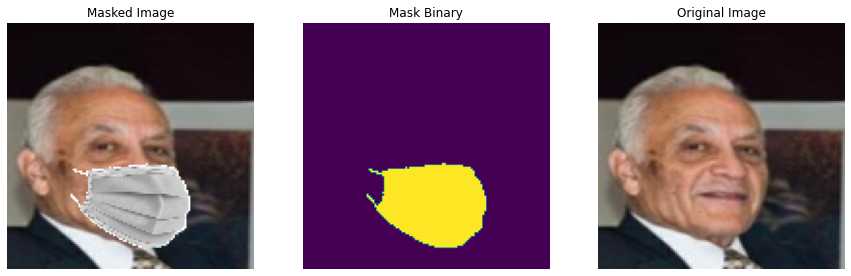

In [ ]:
def mask_on_face(image, from_path=False):

  if from_path == True:
    image=cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  else:
    image = cv2.normalize(image.numpy(), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)
  original_image = image.copy()
  face_np = image
  face_locations = face_recognition.face_locations(face_np)
  face_landmarks = face_recognition.face_landmarks(face_np, face_locations)
  face_landmark = face_landmarks[0]
  face_location = face_locations[0]
  
  # draw_landmarks(face_landmarks, image)
  six_points_on_face, angle = get_six_points(face_landmark, image)
  mask = []
  image, mask_binary = mask_face(
          image, face_location, six_points_on_face, angle
      )

  # compress to face tight
  face_height = face_location[2] - face_location[0]
  face_width = face_location[1] - face_location[3]

  mask_binary[mask_binary>0]=1.0
  mask_binary = np.expand_dims(mask_binary, axis=-1)

  return image, mask_binary, original_image

for _, _, test_image in test_dataset.take(1):
  pass

image, mask_binary, original_image = mask_on_face(test_image[0])

plt.figure(figsize=(15,15))

plt.subplot(1, 3, 1)
plt.title("Masked Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Mask Binary")
plt.imshow(mask_binary[:,:,0])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.show()

##UNET

In [ ]:
def load_image_unet(masked_image, mask_binary, original_image):
  mask_binary = tf.where(tf.math.greater(mask_binary, -1), tf.ones_like(mask_binary), tf.zeros_like(mask_binary))
  return masked_image, mask_binary

In [ ]:
dataset_unet = records.map(read_tfrecord)
dataset_unet = dataset_unet.shuffle(100)
dataset_unet = dataset_unet.map(lambda masked_image, mask_binary, original_image: load_image_unet(masked_image, mask_binary, original_image))
dataset_unet = dataset_unet.batch(1)

valid_dataset_unet = dataset_unet.take(1000)
train_dataset_unet = dataset_unet.skip(1000)

In [ ]:
Inp = tf.keras.Input(
      name='unet_input', shape=(128,128,3), dtype=tf.float32)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(Inp)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
squeeze1 = GlobalAveragePooling2D()(conv1)
excite1 = Reshape((1,1,32))(squeeze1)
excite1 = Dense(32 // 16, activation='relu', kernel_initializer='he_normal', use_bias=False)(excite1)
excite1 = Dense(32, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(excite1)
squeeze_and_excite1 = multiply([conv1, excite1])
pool1 = MaxPooling2D(pool_size=(2, 2), strides=2)(squeeze_and_excite1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
squeeze2 = GlobalAveragePooling2D()(conv2)
excite2 = Reshape((1,1,64))(squeeze2)
excite2 = Dense(64 // 16, activation='relu', kernel_initializer='he_normal', use_bias=False)(excite2)
excite2 = Dense(64, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(excite2)
squeeze_and_excite2 = multiply([conv2, excite2])
pool2 = MaxPooling2D(pool_size=(2, 2))(squeeze_and_excite2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
squeeze3 = GlobalAveragePooling2D()(conv3)
excite3 = Reshape((1,1,128))(squeeze3)
excite3 = Dense(128 // 16, activation='relu', kernel_initializer='he_normal', use_bias=False)(excite3)
excite3 = Dense(128, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(excite3)
squeeze_and_excite3 = multiply([conv3, excite3])
pool3 = MaxPooling2D(pool_size=(2, 2))(squeeze_and_excite3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

# up
# up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv5], mode='concat', concat_axis=3)
up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3 )
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

# up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv3], mode='concat', concat_axis=3)
up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

# up10 = merge([UpSampling2D(size=(2, 2))(conv9), conv2], mode='concat', concat_axis=3)
up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

# up11 = merge([UpSampling2D(size=(2, 2))(conv10), conv1], mode='concat', concat_axis=3)
up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1))(conv9)
#conv10 = Reshape((65536, 1))(conv10) #flatten
conv10 = Activation('sigmoid')(conv10)

In [ ]:
model_unet = Model(inputs=[Inp], outputs=[conv10])
model_unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
unet_input (InputLayer)         [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 32) 896         unet_input[0][0]                 
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_38[0][0]                  
__________________________________________________________________________________________________
global_average_pooling2d_6 (Glo (None, 32)           0           conv2d_39[0][0]                  
____________________________________________________________________________________________

In [ ]:
filepath="unet_checkpoints/epochs:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# load previously trained checkpoint

# !gdown "1DuelvYM3KinOhDLuqBdi5HbTBhSIx9-X"
# checkpoint.restore("epochs_018-val_acc_0.994.hdf5")

In [ ]:
opt =  tf.keras.optimizers.Adam(1e-5)

model_unet.compile(optimizer=opt, loss='BinaryCrossentropy', metrics=['accuracy'])

In [ ]:
history = model_unet.fit(train_dataset_unet, 
                        steps_per_epoch=200, 
                        epochs=20,
                        validation_data=valid_dataset_unet, 
                        validation_steps=4,
                        callbacks=callbacks_list)

Epoch 1/20
200/200 [==============================] - 27s 52ms/step - loss: 0.0388 - accuracy: 0.9848 - val_loss: 0.0465 - val_accuracy: 0.9818

Epoch 00001: val_accuracy improved from -inf to 0.98183, saving model to unet_checkpoints/epochs:001-val_acc:0.982.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
200/200 [==============================] - 13s 64ms/step - loss: 0.0378 - accuracy: 0.9851 - val_loss: 0.0304 - val_accuracy: 0.9869

Epoch 00002: val_accuracy improved from 0.98183 to 0.98694, saving model to unet_checkpoints/epochs:002-val_acc:0.987.hdf5
Epoch 3/20
200/200 [==============================] - 10s 50ms/step - loss: 0.0353 - accuracy: 0.9865 - val_loss: 0.0344 - val_accuracy: 0.9859

Epoch 00003: val_accuracy did not improve from 0.98694
Epoch 4/20
200/200 [==============================] - 13s 63ms/step - loss: 0.0336 - accuracy: 0.9869 - val_loss: 0.0412 - val_accuracy: 0.9842

Epoch 00004: val_accuracy did not improve from 0.98694
Epoch 5/20
200/200 [==============================] - 10s 50ms/step - loss: 0.0314 - accuracy: 0.9876 - val_loss: 0.0296 - val_accuracy: 0.9891

Epoch 00005: val_accuracy improved from 0.98694 to 0.98911, saving model to unet_checkpoints/epochs:005-val_acc:0.989.hdf5
Epoch 6/20
200/200 [==============================] - 13s 65ms/s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


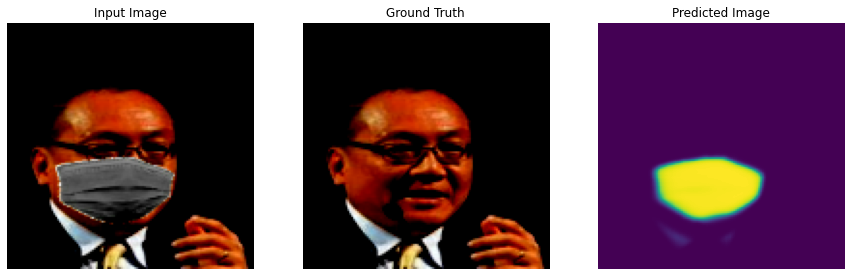

In [ ]:
def generate_images_unet(model, masked_image, original_image):

  prediction = model(masked_image)
  plt.figure(figsize=(15,15))

  display_list = [masked_image[0], original_image[0], prediction[0,:,:,0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])# * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

for masked_image, mask_binary, original_image in dataset.take(1):
  generate_images_unet(model_unet, masked_image, original_image)

## Generative Network (using Pix2Pix model)

Based on the paper "A Novel GAN-Based Network for Unmasking of Masked Face" ([link](https://ieeexplore.ieee.org/abstract/document/9019697)), the network has two discriminators, one for a whole region and one for the area covered only by the mask

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
class Downsample(tf.keras.Model):
    
  def __init__(self, filters, size, apply_batchnorm=True):
    super(Downsample, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    initializer = tf.random_normal_initializer(0., 0.02)

    self.conv1 = tf.keras.layers.Conv2D(filters, 
                                        (size, size), 
                                        strides=2, 
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False)
    if self.apply_batchnorm:
        self.batchnorm = tf.keras.layers.BatchNormalization()
  
  def call(self, x, training):
    x = self.conv1(x)
    if self.apply_batchnorm:
        x = self.batchnorm(x, training=training)
    x = tf.nn.leaky_relu(x)
    return x 


class Upsample(tf.keras.Model):
    
  def __init__(self, filters, size, apply_dropout=False):
    super(Upsample, self).__init__()
    self.apply_dropout = apply_dropout
    initializer = tf.random_normal_initializer(0., 0.02)

    self.up_conv = tf.keras.layers.Conv2DTranspose(filters, 
                                                   (size, size), 
                                                   strides=2, 
                                                   padding='same',
                                                   kernel_initializer=initializer,
                                                   use_bias=False)
    self.batchnorm = tf.keras.layers.BatchNormalization()
    if self.apply_dropout:
        self.dropout = tf.keras.layers.Dropout(0.5)

  def call(self, x1, x2, training):
    x = self.up_conv(x1)
    x = self.batchnorm(x, training=training)
    if self.apply_dropout:
        x = self.dropout(x, training=training)
    x = tf.nn.relu(x)
    x = tf.concat([x, x2], axis=-1)
    return x


class Generator(tf.keras.Model):
    
  def __init__(self):
    super(Generator, self).__init__()
    initializer = tf.random_normal_initializer(0., 0.02)
    
    self.down1 = Downsample(64, 4, apply_batchnorm=False)
    self.down2 = Downsample(128, 4)
    self.down3 = Downsample(256, 4)
    self.down4 = Downsample(512, 4)
    self.down5 = Downsample(512, 4)
    self.down6 = Downsample(512, 4)
    self.down7 = Downsample(512, 4)
    self.down8 = Downsample(512, 4)

    self.up1 = Upsample(512, 4, apply_dropout=True)
    self.up2 = Upsample(512, 4, apply_dropout=True)
    self.up3 = Upsample(512, 4, apply_dropout=True)
    self.up4 = Upsample(512, 4)
    self.up5 = Upsample(256, 4)
    self.up6 = Upsample(128, 4)
    self.up7 = Upsample(64, 4)

    self.last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 
                                                (4, 4), 
                                                strides=2, 
                                                padding='same',
                                                kernel_initializer=initializer)
  
  @tf.function
  def call(self, input_image, mask_binary, training):

    coarse_image = input_image * (1-mask_binary) + mask_binary
    x = tf.concat((coarse_image, mask_binary), -1)

    # x shape == (bs, 128, 128, 4)
    x1 = self.down1(x, training=training) # (bs, 64, 64, 64) 
    x2 = self.down2(x1, training=training) # (bs, 32, 32, 128)
    x3 = self.down3(x2, training=training) # (bs, 16, 16, 256)
    x4 = self.down4(x3, training=training) # (bs, 8, 8, 512)
    x5 = self.down5(x4, training=training) # (bs, 4, 4, 512)
    x6 = self.down6(x5, training=training) # (bs, 2, 2, 512)
    x7 = self.down7(x6, training=training) # (bs, 1, 1, 512)

    x8 = self.up2(x7, x6, training=training) # (bs, 2, 2, 1024)
    x9 = self.up3(x8, x5, training=training) # (bs, 4, 4, 1024)
    x10 = self.up4(x9, x4, training=training) # (bs, 8, 8, 1024)
    x11 = self.up5(x10, x3, training=training) # (bs, 16, 16, 512)
    x12 = self.up6(x11, x2, training=training) # (bs, 32, 32, 256)
    x13 = self.up7(x12, x1, training=training) # (bs, 64, 64, 128)

    x14 = self.last(x13) # (bs, 128, 128, 3)
    x14 = tf.nn.tanh(x14)

    refine_image = input_image * (1-mask_binary) + mask_binary * x14
    refine_image = tf.concat((refine_image, mask_binary), -1)

    x15 = self.down1(refine_image, training=training) # (bs, 64, 64, 64)
    x16 = self.down2(x15, training=training) # (bs, 32, 32, 128)
    x17 = self.down3(x16, training=training) # (bs, 16, 16, 256)
    x18 = self.down4(x17, training=training) # (bs, 8, 8, 512)
    x19 = self.down5(x18, training=training) # (bs, 4, 4, 512)
    x20 = self.down6(x19, training=training) # (bs, 2, 2, 512)
    x21 = self.down7(x20, training=training) # (bs, 1, 1, 512)

    x22 = self.up2(x21, x20, training=training) # (bs, 2, 2, 1024)
    x23 = self.up3(x22, x19, training=training) # (bs, 4, 4, 1024)
    x24 = self.up4(x23, x18, training=training) # (bs, 8, 8, 1024)
    x25 = self.up5(x24, x17, training=training) # (bs, 16, 16, 512)
    x26 = self.up6(x25, x16, training=training) # (bs, 32, 32, 256)
    x27 = self.up7(x26, x15, training=training) # (bs, 64, 64, 128)

    x28 = self.last(x27) # (bs, 128, 128, 3)
    x28 = tf.nn.tanh(x28)

    return x14, x28

In [ ]:
class DiscDownsample(tf.keras.Model):
    
  def __init__(self, filters, size, apply_batchnorm=True):
    super(DiscDownsample, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    initializer = tf.random_normal_initializer(0., 0.02)

    self.conv1 = tf.keras.layers.Conv2D(filters, 
                                        (size, size), 
                                        strides=2, 
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False)
    if self.apply_batchnorm:
        self.batchnorm = tf.keras.layers.BatchNormalization()
  
  def call(self, x, training):
    x = self.conv1(x)
    if self.apply_batchnorm:
        x = self.batchnorm(x, training=training)
    x = tf.nn.leaky_relu(x)
    return x 

class Discriminator(tf.keras.Model):
    
  def __init__(self):
    super(Discriminator, self).__init__()
    initializer = tf.random_normal_initializer(0., 0.02)
    
    self.down1 = DiscDownsample(64, 4, False)
    self.down2 = DiscDownsample(128, 4)
    self.down3 = DiscDownsample(256, 4)
    
    # we are zero padding here with 1 because we need our shape to 
    # go from (batch_size, 32, 32, 256) to (batch_size, 31, 31, 512)
    self.zero_pad1 = tf.keras.layers.ZeroPadding2D()
    self.conv = tf.keras.layers.Conv2D(512, 
                                       (4, 4), 
                                       strides=1, 
                                       kernel_initializer=initializer, 
                                       use_bias=False)
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
    
    # shape change from (batch_size, 31, 31, 512) to (batch_size, 30, 30, 1)
    self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
    self.last = tf.keras.layers.Conv2D(1, 
                                       (4, 4), 
                                       strides=1,
                                       kernel_initializer=initializer)
  
  @tf.function
  def call(self, inp, tar, training):
    # concatenating the input and the target
    x = tf.concat([inp, tar], axis=-1)
    x = self.down1(x, training=training) 
    x = self.down2(x, training=training) 
    x = self.down3(x, training=training) 

    x = self.zero_pad1(x) 
    x = self.conv(x)      
    x = self.batchnorm1(x, training=training)
    x = tf.nn.leaky_relu(x)
    
    x = self.zero_pad2(x) 
    # don't add a sigmoid activation here since
    # the loss function expects raw logits.
    x = self.last(x) 

    return x

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = tf.compat.v1.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_real_output), 
                                              logits = disc_real_output)
  generated_loss = tf.compat.v1.losses.sigmoid_cross_entropy(multi_class_labels = tf.zeros_like(disc_generated_output), 
                                                   logits = disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
def generator_loss(disc_generated_output, gen_output, target, lambda_gan, lambda_rc=100):
  gan_loss = tf.compat.v1.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_generated_output),
                                             logits = disc_generated_output) 
  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(target, gen_output, 1.0))

  reconstruction_loss = l1_loss + ssim_loss

  total_gen_loss = (lambda_gan * gan_loss) + (lambda_rc * reconstruction_loss)

  return total_gen_loss

In [ ]:
generator_optimizer = optimizers.Adam(2e-5, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(2e-5, beta_1=0.5)

## Load previously trained checkpoint

In [ ]:
checkpoint_dir = 'GAN_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
!gdown --id "1Aqq9Vjt2GZpZNqu-3QdqiDo5O9OgWS-X"
!unzip checkpoints.zip
checkpoint.restore(tf.train.latest_checkpoint("GAN_checkpoints/"))

Downloading...
From: https://drive.google.com/uc?id=1Aqq9Vjt2GZpZNqu-3QdqiDo5O9OgWS-X
To: /content/checkpoints.zip
1.34GB [00:07, 177MB/s]
Archive:  checkpoints.zip
  inflating: GAN_checkpoints/checkpoint  
  inflating: GAN_checkpoints/ckpt-epoch:4-2.data-00000-of-00001  
  inflating: GAN_checkpoints/ckpt-epoch:4-2.index  
  inflating: GAN_checkpoints/ckpt-epoch:5-1.data-00000-of-00001  
  inflating: GAN_checkpoints/ckpt-epoch:5-1.index  
  inflating: GAN_checkpoints/ckpt-epoch:5-3.data-00000-of-00001  
  inflating: GAN_checkpoints/ckpt-epoch:5-3.index  
  inflating: __results___files/__results___23_0.png  
  inflating: __results___files/__results___24_0.png  


## Import VGG Face Model for perceptual loss

In [ ]:
vgg19 = tf.keras.applications.VGG19(weights="imagenet", include_top=False, input_shape=(256,256,3), pooling=None)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
vgg_model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block4_pool').output)

In [ ]:
for layer in vgg_model.layers:
  layer.trainable = False

## Define Functions for displaying results and training

In [ ]:
def generate_images(model, test_input, mask_binary, target):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get 
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, mask_binary, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], target[0], prediction[0][0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [ ]:
def train(dataset, epochs):  
  for epoch in range(epochs):
    start = time.time()

    for step, (input_image, mask_binary, target) in enumerate(dataset):
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        first_gen_output, second_gen_output = generator(input_image, mask_binary, training=True)

        first_output_whole = input_image * (1 - mask_binary) + first_gen_output * mask_binary
        second_output_whole = input_image * (1 - mask_binary) + second_gen_output * mask_binary

        disc_real_output = discriminator(input_image, target, training=True)
        first_disc_generated_output = discriminator(first_output_whole, target, training=True)
        second_disc_generated_output = discriminator(second_output_whole, target, training=True)

        first_gen_total_loss = generator_loss(first_disc_generated_output, first_gen_output, target, lambda_gan=0.3)
        second_gen_total_loss = generator_loss(second_disc_generated_output, second_gen_output, target, lambda_gan=0.7)
        first_disc_loss = discriminator_loss(disc_real_output, first_disc_generated_output)
        second_disc_loss = discriminator_loss(disc_real_output, second_disc_generated_output)
        total_disc_loss = (first_disc_loss + second_disc_loss) * 0.5

        # Perceptual loss
        feature_fake = vgg_model(second_output_whole)
        feature_real = vgg_model(input_image)
        perceptual_loss = tf.keras.losses.mse(feature_fake, feature_real)
        total_loss = K.mean(perceptual_loss) + first_gen_total_loss + second_gen_total_loss + first_disc_loss * 0.3 + second_disc_loss * 0.7

      generator_gradients = gen_tape.gradient(total_loss,
                                              generator.trainable_variables)
      discriminator_gradients = disc_tape.gradient(total_disc_loss, 
                                                   discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(generator_gradients, 
                                              generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(discriminator_gradients, 
                                                  discriminator.trainable_variables))
      
      if (step+1) % 5000 == 0:
        print(
            "Training loss (for one batch) at step %d: %.4f"
            % ((step+1), float(total_loss))
        )
        end = time.time()
        temp = end-start
        hours = temp//3600
        temp = temp - 3600*hours
        minutes = temp//60
        seconds = temp - 60*minutes
        print("Time since start of epoch: %d:%d:%d"%(hours,minutes,seconds))
        print("Time now is {}".format(time.asctime(time.localtime())))
        print("Seen so far: %d samples" % (step + 1))

    if epoch % 1 == 0:
        clear_output(wait=True)
        for input_image, mask_binary, target in valid_dataset.take(1):
          generate_images(generator, input_image, mask_binary, target)
          
    # saving (checkpoint) the model every 5 epoch
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec, ending at {}\n'.format(epoch + 1,
                                                        time.time()-start, time.asctime(time.localtime())))

In [ ]:
train(train_dataset, 10)

## Taking a look at the results

The results give a good enough estimate of how someone looks without their mask. There is still quite abit of patchiness from where the mask was previously, as well as not being very clear due to the low resolution of 128x128 pixels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


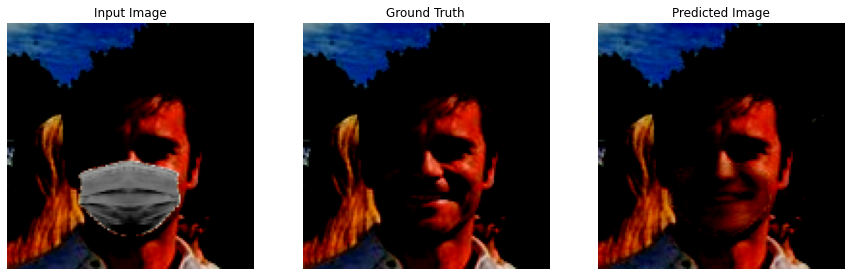

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


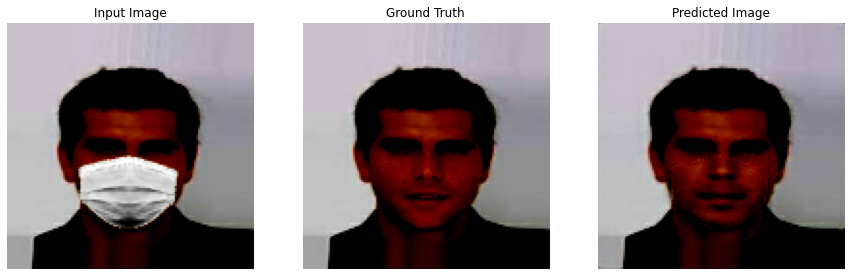

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


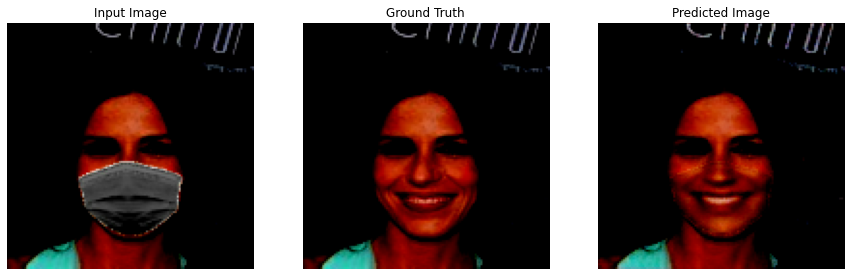

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


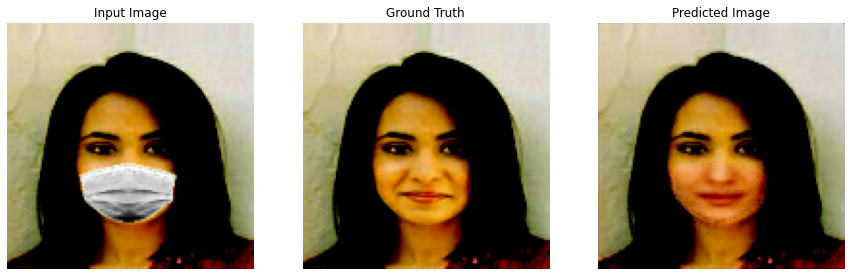

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


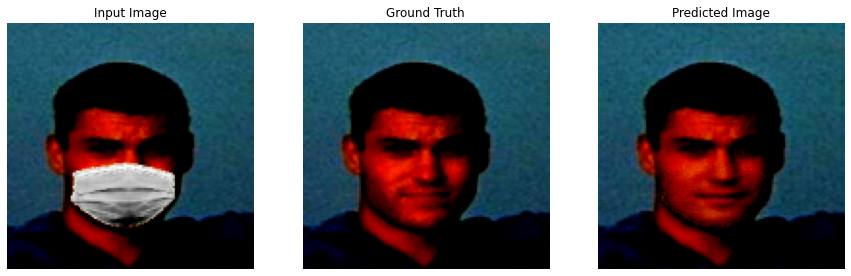

In [ ]:
 i = 0
 for input_image, mask_binary, target in test_dataset:
  i+=1
  generate_images(generator, input_image, mask_binary, target)
  if i==5:
    break